# Import Dataset

## **Import Modules**

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os

from os import listdir
from os.path import isfile, join

## **Load OPPORTUNITY Dataset**

In [2]:
mypath = 'Dataset/OpportunityDataset/dataset'
basepath = ''

files = [f for f in listdir(mypath) if isfile(join(mypath, f)) and f[-3:]=='dat' and f[-9:-4]!='Drill']
files = sorted(files)
files = [join(mypath,f) for f in files]

In [3]:
def load_data(filename):
  g = 9.8
  xyz_cols = ['x','y','z']
  using_cols = [0,23,24,25,243]
  
  df = pd.read_csv(filename, sep='\s+', usecols=using_cols,names=['ts','x','y','z','label'], header=None, engine='python')

  df = df.dropna(axis='index')
  df[xyz_cols] = df[xyz_cols].apply(lambda x: x/1000 * g)
  
  return df

In [4]:
df1 = load_data(files[0])
df2 = load_data(files[1])
df3 = load_data(files[2])

In [5]:
df1['label'].value_counts()

1    22168
0    12951
4     7437
2     6465
5     1128
Name: label, dtype: int64

In [6]:
# df2['label'].value_counts()

In [7]:
# df3['label'].value_counts()

# Preprocess Data

## **Import sklearn Library**

In [8]:
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

## **Prepare Data**

In [9]:
def normalize_data(series):
  series = np.array(series)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(series)
  
  return scaler.transform(series)

In [10]:
def prepare_data(df1):
  feature_cols = ['x','y','z']
  label_cols = ['label']

  X_series = df1[feature_cols]
  y_series = df1[label_cols]

  X_train = normalize_data(X_series)
  # Convert labels to a binary vector
  y_train = label_binarize(y_series.values, classes=[0,1,2,3,4,5])

  length = len(X_train)

  X_train = X_train.reshape((length,1,TRIAXIAL))
  y_train = y_train.reshape((length,1,LABEL_COUNT))
  
  return X_train, y_train

In [11]:
# define parameters
LABEL_COUNT = 6
TRIAXIAL = 3

In [12]:
# Load data from a certain dataframe
X_train, y_train = prepare_data(df1)
X_val, y_val = prepare_data(df2)
X_test, y_test = prepare_data(df3)

In [13]:
VALIDAT_LEN = len(X_val)
print(VALIDAT_LEN)

X_train_1 = X_train[:VALIDAT_LEN]
y_train_1 = y_train[:VALIDAT_LEN]

X_test = X_test[:VALIDAT_LEN]
y_test = y_test[:VALIDAT_LEN]

31145


In [14]:
TESTING_LEN = len(X_test)
# TRAINING_LEN = len(X_train)

print(X_train_1.shape, X_val.shape, X_test.shape)
print(y_train_1.shape, y_val.shape, y_test.shape)

print()
print(VALIDAT_LEN, TESTING_LEN)
print()

print(X_test[0])
print(y_test[0])

(31145, 1, 3) (31145, 1, 3) (31145, 1, 3)
(31145, 1, 6) (31145, 1, 6) (31145, 1, 6)

31145 31145

[[0.66486703 0.56163583 0.55995298]]
[[1 0 0 0 0 0]]


In [15]:
LABELS = [0,1,2,4,5]

In [16]:
d1 = y_val
# print(len(d1))
print(d1[1600][0],'\n')
  
cnter = [0,0,0,0,0,0]

for x in range(len(d1)):
  for a in range(len(d1[0])):
    for lb in LABELS:
      if d1[x][0][a]==1 and a==lb:
        cnter[a] += 1
        
print(cnter)

[0 1 0 0 0 0] 

[6686, 0, 0, 0, 0, 0]


In [17]:
%run RNN_model.ipynb

Using TensorFlow backend.


In [18]:
# rnn_model = create_rnn_model(X_train_1)
# rnn_model.summary()

# rnn_model = compile_model(rnn_model)
# rnn_model = train_model(rnn_model, X_train_1, y_train_1, 
#                         X_val, y_val)

# y_pred = get_y_predict(rnn_model, X_test)

 # Classification

## Import keras library

In [19]:
import keras

from keras import metrics
from keras import callbacks
from keras import models

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import GRU, Input, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

## **Create RNN Model**

In [20]:
def create_rnn_model(X_val):
  model = Sequential()
  
  # RNN layers
  gru_layer_1 = GRU(units=GRU_UNITS, 
                 dropout=0.1, recurrent_dropout=0.1, 
                 return_sequences=True,
                 input_shape=(X_val.shape[1], X_val.shape[2]))
  
  model.add(gru_layer_1)
  model.add(Activation('relu'))
  
  gru_layer_2 = GRU(units=GRU_UNITS_2, 
                 dropout=0.1, recurrent_dropout=0.1, 
                 return_sequences=True)

  model.add(gru_layer_2)
  model.add(Activation('relu'))
  
  # Output layers
  output = Dense(LABEL_COUNT, activation='softmax')
#   drpout = Dropout(0.08, seed=42)
  model.add(output)
#   model.add(drpout)
  
  return model

In [21]:
# define GRU units
GRU_UNITS = 90
GRU_UNITS_2 = 90

rnn_model = create_rnn_model(X_val)
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 90)             25380     
_________________________________________________________________
activation_1 (Activation)    (None, 1, 90)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 1, 90)             48870     
_________________________________________________________________
activation_2 (Activation)    (None, 1, 90)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 6)              546       
Total params: 74,796
Trainable params: 74,796
Non-trainable params: 0
_________________________________________________________________


In [22]:
initial_lrate = 0.001

optimizer = keras.optimizers.Adam(lr=initial_lrate)

rnn_model.compile(optimizer=optimizer,
                  loss=keras.losses.categorical_crossentropy,
                  metrics=[metrics.categorical_accuracy])

## Train the Model

In [23]:
drop = 0.9
epochs_drop = 9.0

decay_rate = []

In [24]:
def scheduler(epoch):
  lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
  decay_rate.append(lrate)
  
  return lrate

In [25]:
chkpoint_path = basepath + 'model_chkpoints/weights.best.hdf5'

model_chkpoint = ModelCheckpoint(chkpoint_path, verbose=0, save_best_only=True, save_weights_only=True)
early_stop = EarlyStopping(monitor='categorical_accuracy', min_delta=0.1, patience=10, verbose=0)
lrate = LearningRateScheduler(scheduler, verbose=1)

In [26]:
BATCH_SIZE = 50
EPOCHS = 50

In [27]:
model_fit = rnn_model.fit(X_train_1, y_train_1,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_data=(X_val, y_val),
                 verbose=1,
                 callbacks=[model_chkpoint, early_stop, lrate])

Train on 31145 samples, validate on 31145 samples
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
31145/31145 [==============================] - 29s 931us/step - loss: 1.1872 - categorical_accuracy: 0.4984 - val_loss: 1.7117 - val_categorical_accuracy: 0.3297
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
31145/31145 [==============================] - 18s 570us/step - loss: 1.1177 - categorical_accuracy: 0.5227 - val_loss: 1.5880 - val_categorical_accuracy: 0.3313
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
31145/31145 [==============================] - 18s 567us/step - loss: 1.0511 - categorical_accuracy: 0.5576 - val_loss: 1.4653 - val_categorical_accuracy: 0.3321
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
31145/31145 [==============================] - 18s 569us/step - loss: 1.0055 - categorical_accuracy: 0.5591 - val_loss: 1.4094 - val_categorical_acc

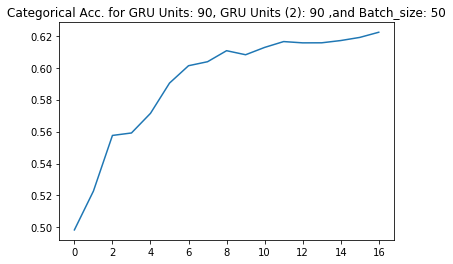

In [28]:
plt.plot(model_fit.history['categorical_accuracy'])
plt.title('Categorical Acc. for GRU Units: ' + str(GRU_UNITS) + ', GRU Units (2): ' + str(GRU_UNITS_2) + ' ,and Batch_size: ' + str(BATCH_SIZE))

plt.savefig(basepath + 'Graphs/RNN_accuracy_' + str(GRU_UNITS) + '_' + str(GRU_UNITS_2) + '_' + str(BATCH_SIZE) + '.png', dpi=200)
plt.show()

## Evaluate the Model

In [29]:
rnn_model.load_weights(chkpoint_path)

In [30]:
y_pred = rnn_model.predict(X_test, batch_size=BATCH_SIZE)

In [31]:
# get the max probability for label binarized y value
def convert_y(y):
  y_conv = [j for i in range(len(y)) for j in range(len(y[i][0])) if y[i][0][j]==np.amax(y[i][0])]
  return np.array(y_conv)

In [32]:
print(convert_y(y_test))
print(convert_y(y_pred))

[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]


In [33]:
y_t = convert_y(y_test)
y_p = convert_y(y_pred)
      
print("GRU units: ", GRU_UNITS)
print('GRU units 2: ', GRU_UNITS_2)
print("Batch size: ", BATCH_SIZE)
print()
  
acc_score = accuracy_score(y_t, y_p)

print("Accuracy: ", acc_score)

GRU units:  90
GRU units 2:  90
Batch size:  50

Accuracy:  0.4047519666078022


## Confusion Matrix

In [34]:
%run eval_score.ipynb

In [35]:
LABELS = ['Nan','Stand','Walk','Sit','Sleep']

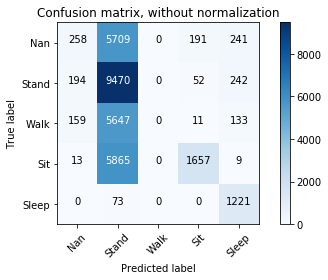

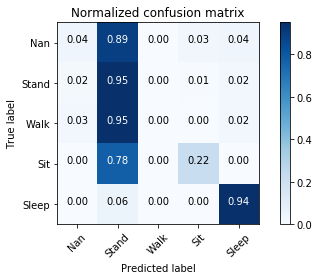

In [36]:
show_conf_matrix(y_t, y_p, LABELS)

In [37]:
show_clf_report(y_t, y_p, LABELS)

              precision    recall  f1-score   support

         Nan       0.41      0.04      0.07      6399
       Stand       0.35      0.95      0.52      9958
        Walk       0.00      0.00      0.00      5950
         Sit       0.87      0.22      0.35      7544
       Sleep       0.66      0.94      0.78      1294

   micro avg       0.40      0.40      0.40     31145
   macro avg       0.46      0.43      0.34     31145
weighted avg       0.44      0.40      0.30     31145



/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Note (1)
* **0 - NaN**
* **1 - Stand**
* **2 - Walk**
* **4 - Sit**
* **5 - Lie**